In [ ]:
!nvidia-smi

Mon Jun 17 18:14:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!apt-get -qq install -y libopencv-dev

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bfly.jpg to bfly.jpg


#Gray Scale Filter

In [ ]:
%%writefile main1.cu

#include <iostream>
#include <vector>
#include <cmath>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>
#include "device_launch_parameters.h"

using namespace std;
using namespace cv;


//kernel
__global__ void convertToGray(const unsigned char* rgbImage, unsigned char* grayImage, int width, int height, int channels) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row >= height || col >= width) return;

    int grayIndex = row * width + col;
    int rgbIndex = grayIndex * channels;

    float grayValue = 0.21f * rgbImage[rgbIndex] + 0.72f * rgbImage[rgbIndex + 1] + 0.07f * rgbImage[rgbIndex + 2];

    grayImage[grayIndex] = static_cast<unsigned char>(grayValue);
}

void grayscaleConversion(const unsigned char* hostRgbImage, unsigned char* hostGrayImage, int width, int height, int channels) {
    const int threadsPerBlock = 32;
    const int gridX = static_cast<int>(ceil(static_cast<float>(width) / threadsPerBlock));
    const int gridY = static_cast<int>(ceil(static_cast<float>(height) / threadsPerBlock));

    dim3 dimBlock(threadsPerBlock, threadsPerBlock);
    dim3 dimGrid(gridX, gridY);

    unsigned char* deviceRgbImage;
    unsigned char* deviceGrayImage;

    const size_t rgbSize = width * height * channels * sizeof(unsigned char);
    const size_t graySize = width * height * sizeof(unsigned char);

    cudaMalloc(&deviceRgbImage, rgbSize);
    cudaMalloc(&deviceGrayImage, graySize);

    cudaMemcpy(deviceRgbImage, hostRgbImage, rgbSize, cudaMemcpyHostToDevice);

    convertToGray<<<dimGrid, dimBlock>>>(deviceRgbImage, deviceGrayImage, width, height, channels);

    cudaMemcpy(hostGrayImage, deviceGrayImage, graySize, cudaMemcpyDeviceToHost);

    cudaFree(deviceRgbImage);
    cudaFree(deviceGrayImage);
}

int main(int argc, char* argv[]) {
    if (argc != 2) {
        cerr << "Usage: " << argv[0] << " <image_file>" << endl;
        return EXIT_FAILURE;
    }

    Mat colorImage = imread(argv[1], IMREAD_COLOR);
    if (colorImage.empty()) {
        cerr << "Error: Unable to read image file " << argv[1] << endl;
        return EXIT_FAILURE;
    }

    int width = colorImage.cols;
    int height = colorImage.rows;
    int channels = colorImage.channels();

    vector<unsigned char> grayImage(width * height);

    grayscaleConversion(colorImage.data, grayImage.data(), width, height, channels);

    cout << "Original Image Pixel (0,0): "
         << static_cast<int>(colorImage.data[0]) << ","
         << static_cast<int>(colorImage.data[1]) << ","
         << static_cast<int>(colorImage.data[2]) << endl;

    cout << "Gray Image Pixel (0,0): " << static_cast<int>(grayImage[0]) << endl;

    Mat grayImageMat(height, width, CV_8UC1, grayImage.data());
    imwrite("output_gray.jpg", grayImageMat);
    imwrite("output_color.jpg", colorImage);

    return EXIT_SUCCESS;
}



Writing main1.cu


In [ ]:
!nvcc -I/usr/include/opencv4 -L/usr/lib -o main1 main1.cu -lopencv_core -lopencv_highgui -lopencv_imgcodecs -Xcompiler="-Wno-overloaded-virtual"
!./main1 bfly.jpg

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

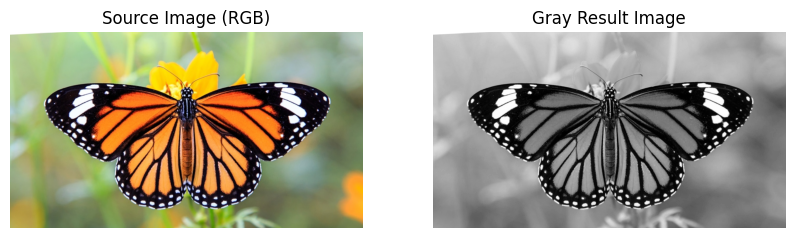

In [ ]:
import cv2
from matplotlib import pyplot as plt

source_image = cv2.imread('output_color.jpg')
gray_result_image = cv2.imread('output_gray.jpg', cv2.IMREAD_GRAYSCALE)

#  BGR to RGB
source_image_rgb = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(source_image_rgb)
plt.title('Source Image (RGB)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray_result_image, cmap='gray')
plt.title('Gray Result Image')
plt.axis('off')

plt.show()


#Blur filter

In [ ]:
%%writefile main2.cu

#include <iostream>
#include <vector>
#include <cmath>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>
#include "device_launch_parameters.h"

using namespace std;
using namespace cv;

// Kernel CUDA para aplicar el filtro de desenfoque
__global__ void applyBlurFilter(const unsigned char* inputImage, unsigned char* outputImage, int width, int height, int channels, int blurRadius) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row >= height || col >= width) return;

    int pixelIndex = row * width + col;

    for (int chan = 0; chan < channels; ++chan) {
        int sum = 0;
        int count = 0;

        for (int r = row - blurRadius; r <= row + blurRadius; ++r) {
            for (int c = col - blurRadius; c <= col + blurRadius; ++c) {
                if (r >= 0 && r < height && c >= 0 && c < width) {
                    sum += static_cast<int>(inputImage[(r * width + c) * channels + chan]);
                    ++count;
                }
            }
        }

        outputImage[pixelIndex * channels + chan] = static_cast<unsigned char>(sum / count);
    }
}

// Función para gestionar el desenfoque de la imagen usando CUDA
void blurImage(const unsigned char* hostRgbImage, unsigned char* hostBlurImage, int width, int height, int channels, int blurRadius) {
    const int threadsPerBlock = 32;
    const int gridX = static_cast<int>(ceil(static_cast<float>(width) / threadsPerBlock));
    const int gridY = static_cast<int>(ceil(static_cast<float>(height) / threadsPerBlock));

    dim3 dimBlock(threadsPerBlock, threadsPerBlock);
    dim3 dimGrid(gridX, gridY);

    unsigned char* deviceRgbImage;
    unsigned char* deviceBlurImage;

    const size_t rgbSize = width * height * channels * sizeof(unsigned char);

    cudaMalloc(&deviceRgbImage, rgbSize);
    cudaMalloc(&deviceBlurImage, rgbSize);

    cudaMemcpy(deviceRgbImage, hostRgbImage, rgbSize, cudaMemcpyHostToDevice);

    applyBlurFilter<<<dimGrid, dimBlock>>>(deviceRgbImage, deviceBlurImage, width, height, channels, blurRadius);

    cudaMemcpy(hostBlurImage, deviceBlurImage, rgbSize, cudaMemcpyDeviceToHost);

    cudaFree(deviceRgbImage);
    cudaFree(deviceBlurImage);
}

int main(int argc, char* argv[]) {
    if (argc != 2) {
        cerr << "Usage: " << argv[0] << " <image_file>" << endl;
        return EXIT_FAILURE;
    }

    Mat colorImage = imread(argv[1], IMREAD_COLOR);
    if (colorImage.empty()) {
        cerr << "Error: Unable to read image file " << argv[1] << endl;
        return EXIT_FAILURE;
    }

    int width = colorImage.cols;
    int height = colorImage.rows;
    int channels = colorImage.channels();

    vector<unsigned char> blurResult(width * height * channels);

    int blurRadius = 8;
    blurImage(colorImage.data, blurResult.data(), width, height, channels, blurRadius);

    cout << "Original Image Pixel (0,0): "
         << static_cast<int>(colorImage.data[0]) << ","
         << static_cast<int>(colorImage.data[1]) << ","
         << static_cast<int>(colorImage.data[2]) << endl;

    cout << "Blurred Image Pixel (0,0): "
         << static_cast<int>(blurResult[0]) << ","
         << static_cast<int>(blurResult[1]) << ","
         << static_cast<int>(blurResult[2]) << endl;

    Mat blurImageMat(height, width, CV_8UC3, blurResult.data());
    imwrite("bl_Res.jpg", blurImageMat);
    imwrite("image.jpg", colorImage);

    return EXIT_SUCCESS;
}


Writing main2.cu


In [ ]:
!nvcc -I/usr/include/opencv4 -L/usr/lib -o main2 main2.cu -lopencv_core -lopencv_highgui -lopencv_imgcodecs
!./main2 bfly.jpg

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

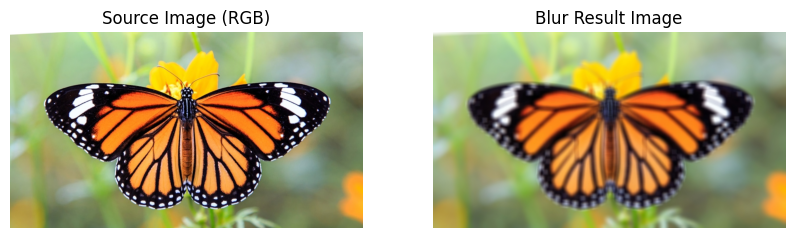

In [ ]:
import cv2
from matplotlib import pyplot as plt

source_image = cv2.imread('image.jpg')
bl_res_image = cv2.imread('bl_Res.jpg')

source_image_rgb = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
blur_image_rgb = cv2.cvtColor(bl_res_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(source_image_rgb)
plt.title('Source Image (RGB)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blur_image_rgb)
plt.title('Blur Result Image')
plt.axis('off')

plt.show()


In [ ]:
%%writefile matrix_mul.cu
#include <stdio.h>
#include <cuda.h>
#include <stdlib.h>

#define TILE_WIDTH 16  // Tamaño del tile para procesamiento en memoria compartida
#define BATCH_SIZE 2048  // Tamaño del lote para procesamiento por lotes

// Declaración de los kernels
__global__ void MatrixMulKernel(float* d_M, float* d_N, float* d_P, int Width, int batchOffset);
__global__ void MatrixMulKernelGlobal(float* d_M, float* d_N, float* d_P, int Width, int batchOffset);

// Función para comprobar errores de CUDA
void checkCudaError(cudaError_t error, const char* msg) {
    if (error != cudaSuccess) {
        fprintf(stderr, "CUDA error: %s: %s\n", msg, cudaGetErrorString(error));
        exit(EXIT_FAILURE);
    }
}

int main() {
    FILE* file = fopen("timings.txt", "w");  // Abrir archivo para guardar tiempos de ejecución
    if (!file) {
        fprintf(stderr, "Failed to open timings.txt for writing\n");
        return -1;
    }

    // Escribir encabezado en el archivo
    fprintf(file, "Size\tShared Memory Time (ms)\tGlobal Memory Time (ms)\n");

    // Iterar sobre diferentes tamaños de matrices
    for (int Width = 32; Width <= 8032; Width += 100) {
        size_t size = Width * Width * sizeof(float);  // Calcular tamaño en bytes de la matriz

        // Reservar memoria en el host
        float* h_M = (float*)malloc(size);
        float* h_N = (float*)malloc(size);
        float* h_P = (float*)malloc(size);

        // Inicializar matrices en el host con valores aleatorios
        for (int i = 0; i < Width * Width; i++) {
            h_M[i] = static_cast<float>(rand()) / RAND_MAX;
            h_N[i] = static_cast<float>(rand()) / RAND_MAX;
        }

        // Reservar memoria en el dispositivo (GPU)
        float *d_M, *d_N, *d_P;
        checkCudaError(cudaMalloc(&d_M, size), "Allocate d_M");
        checkCudaError(cudaMalloc(&d_N, size), "Allocate d_N");
        checkCudaError(cudaMalloc(&d_P, size), "Allocate d_P");

        // Copiar datos desde el host al dispositivo
        checkCudaError(cudaMemcpy(d_M, h_M, size, cudaMemcpyHostToDevice), "Copy h_M to d_M");
        checkCudaError(cudaMemcpy(d_N, h_N, size, cudaMemcpyHostToDevice), "Copy h_N to d_N");

        // Definir dimensiones de los bloques y la rejilla
        dim3 dimBlock(TILE_WIDTH, TILE_WIDTH);
        dim3 dimGrid((Width + TILE_WIDTH - 1) / TILE_WIDTH, (Width + TILE_WIDTH - 1) / TILE_WIDTH);

        // Crear eventos CUDA para medir el tiempo de ejecución
        cudaEvent_t start, stop;
        checkCudaError(cudaEventCreate(&start), "Create start event");
        checkCudaError(cudaEventCreate(&stop), "Create stop event");

        // Medir tiempo de ejecución del kernel con memoria compartida
        checkCudaError(cudaEventRecord(start, 0), "Record start event");
        for (int batchOffset = 0; batchOffset < Width; batchOffset += BATCH_SIZE) {
            MatrixMulKernel<<<dimGrid, dimBlock>>>(d_M, d_N, d_P, Width, batchOffset);
        }
        checkCudaError(cudaEventRecord(stop, 0), "Record stop event");
        checkCudaError(cudaEventSynchronize(stop), "Synchronize stop event");

        float shared_time = 0;
        checkCudaError(cudaEventElapsedTime(&shared_time, start, stop), "Elapsed time for shared memory kernel");

        checkCudaError(cudaGetLastError(), "Kernel launch failed (shared memory)");

        // Medir tiempo de ejecución del kernel con memoria global
        checkCudaError(cudaEventRecord(start, 0), "Record start event");
        for (int batchOffset = 0; batchOffset < Width; batchOffset += BATCH_SIZE) {
            MatrixMulKernelGlobal<<<dimGrid, dimBlock>>>(d_M, d_N, d_P, Width, batchOffset);
        }
        checkCudaError(cudaEventRecord(stop, 0), "Record stop event");
        checkCudaError(cudaEventSynchronize(stop), "Synchronize stop event");

        float global_time = 0;
        checkCudaError(cudaEventElapsedTime(&global_time, start, stop), "Elapsed time for global memory kernel");

        checkCudaError(cudaGetLastError(), "Kernel launch failed (global memory)");

        // Escribir resultados en el archivo y en la consola
        fprintf(file, "%d\t%.3f\t%.3f\n", Width, shared_time, global_time);
        printf("Matrix Size: %d, Shared Memory Time: %.3f ms, Global Memory Time: %.3f ms\n", Width, shared_time, global_time);

        // Liberar memoria del host y del dispositivo
        free(h_M);
        free(h_N);
        free(h_P);
        cudaFree(d_M);
        cudaFree(d_N);
        cudaFree(d_P);

        // Destruir eventos CUDA
        checkCudaError(cudaEventDestroy(start), "Destroy start event");
        checkCudaError(cudaEventDestroy(stop), "Destroy stop event");
    }

    fclose(file);  // Cerrar archivo
    return 0;
}

// Kernel que usa memoria global para la multiplicación de matrices
__global__ void MatrixMulKernelGlobal(float* M, float* N, float* P, int Width, int batchOffset) {
    int Row = blockIdx.y * blockDim.y + threadIdx.y;  // Calcular fila de la matriz resultante
    int Col = blockIdx.x * blockDim.x + threadIdx.x;  // Calcular columna de la matriz resultante

    if ((Row < Width) && (Col < Width)) {
        float Pvalue = 0;
        // Multiplicación de matrices usando memoria global
        for (int k = batchOffset; k < min(batchOffset + BATCH_SIZE, Width); ++k) {
            Pvalue += M[Row * Width + k] * N[k * Width + Col];
        }
        atomicAdd(&P[Row * Width + Col], Pvalue);  // Uso de atomicAdd para evitar conflictos de escritura
    }
}

// Kernel que usa memoria compartida para la multiplicación de matrices
__global__ void MatrixMulKernel(float* M, float* N, float* P, int Width, int batchOffset) {
    __shared__ float Mds[TILE_WIDTH][TILE_WIDTH];  // Declarar memoria compartida para submatrices
    __shared__ float Nds[TILE_WIDTH][TILE_WIDTH];

    int bx = blockIdx.x;  int by = blockIdx.y;  // Índices de bloque
    int tx = threadIdx.x; int ty = threadIdx.y;  // Índices de hilo

    int Row = by * TILE_WIDTH + ty;  // Calcular fila de la matriz resultante
    int Col = bx * TILE_WIDTH + tx;  // Calcular columna de la matriz resultante

    float Pvalue = 0;

    // Multiplicación de matrices usando memoria compartida
    for (int ph = batchOffset / TILE_WIDTH; ph < min((batchOffset + BATCH_SIZE) / TILE_WIDTH, Width / TILE_WIDTH); ++ph) {
        Mds[ty][tx] = M[Row * Width + (ph * TILE_WIDTH + tx)];
        Nds[ty][tx] = N[(ph * TILE_WIDTH + ty) * Width + Col];

        __syncthreads();  // Sincronizar para asegurar que toda la memoria compartida está cargada

        for (int k = 0; k < TILE_WIDTH; ++k)
            Pvalue += Mds[ty][k] * Nds[k][tx];

        __syncthreads();  // Sincronizar para asegurar que todos los hilos han terminado con los datos actuales
    }

    atomicAdd(&P[Row * Width + Col], Pvalue);  // Uso de atomicAdd para evitar conflictos de escritura
}


Overwriting matrix_mul.cu


In [ ]:
!nvcc -o matrix_mul matrix_mul.cu
!./matrix_mul

Matrix Size: 32, Shared Memory Time: 0.205 ms, Global Memory Time: 0.021 ms
Matrix Size: 132, Shared Memory Time: 0.032 ms, Global Memory Time: 0.032 ms
Matrix Size: 232, Shared Memory Time: 0.094 ms, Global Memory Time: 0.103 ms
Matrix Size: 332, Shared Memory Time: 0.225 ms, Global Memory Time: 0.323 ms
Matrix Size: 432, Shared Memory Time: 0.448 ms, Global Memory Time: 0.566 ms
Matrix Size: 532, Shared Memory Time: 0.861 ms, Global Memory Time: 1.259 ms
Matrix Size: 632, Shared Memory Time: 1.398 ms, Global Memory Time: 1.847 ms
Matrix Size: 732, Shared Memory Time: 2.156 ms, Global Memory Time: 3.162 ms
Matrix Size: 832, Shared Memory Time: 3.119 ms, Global Memory Time: 4.845 ms
Matrix Size: 932, Shared Memory Time: 4.562 ms, Global Memory Time: 6.626 ms
Matrix Size: 1032, Shared Memory Time: 6.045 ms, Global Memory Time: 7.717 ms
Matrix Size: 1132, Shared Memory Time: 7.883 ms, Global Memory Time: 11.839 ms
Matrix Size: 1232, Shared Memory Time: 9.654 ms, Global Memory Time: 13.46

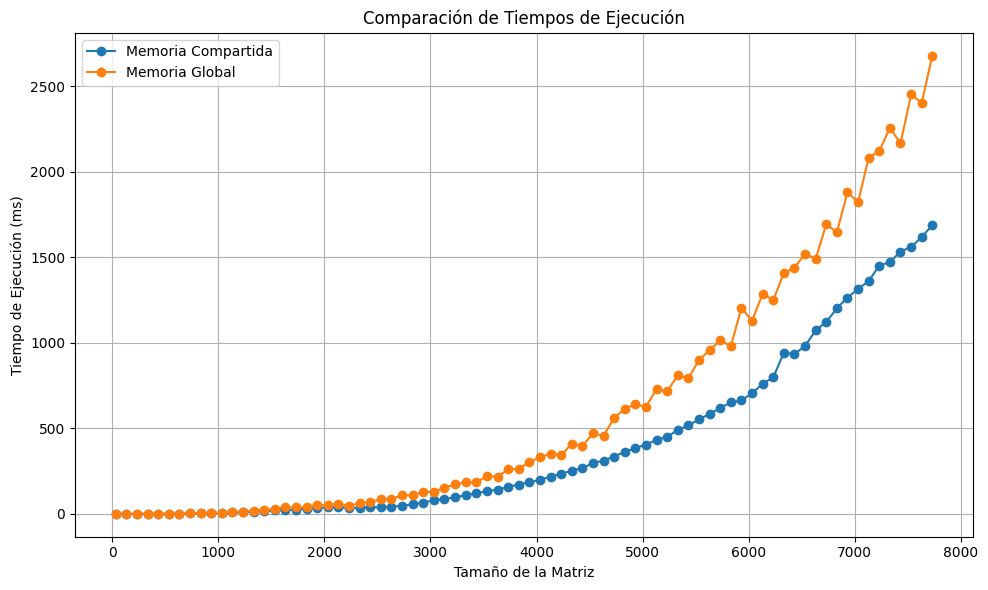

In [ ]:
import matplotlib.pyplot as plt

sizes = []
shared_times = []
global_times = []

with open("timings.txt", "r") as file:
    next(file)
    for line in file:
        size, shared_time, global_time = line.split("\t")
        sizes.append(int(size))
        shared_times.append(float(shared_time))
        global_times.append(float(global_time))

plt.figure(figsize=(10, 6))
plt.plot(sizes, shared_times, marker='o', label='Memoria Compartida')
plt.plot(sizes, global_times, marker='o', label='Memoria Global')

plt.title('Comparación de Tiempos de Ejecución')
plt.xlabel('Tamaño de la Matriz')
plt.ylabel('Tiempo de Ejecución (ms)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()